In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

/home/thanhfvux/AGNews_classify/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-05 02:55:02.611358: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 02:55:02.645029: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-05 02:55:03.369944: I tensorflow/core/util/port.cc:153] oneDNN custom operations a

In [2]:
dataset = load_dataset("ag_news")

In [3]:
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

print(train_df.head())
print(train_df['label'].unique())


                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
3  Iraq Halts Oil Exports from Main Southern Pipe...      2
4  Oil prices soar to all-time record, posing new...      2
[2 3 1 0]


In [4]:
print(train_df.isna().sum())
print(train_df.duplicated().sum())

text     0
label    0
dtype: int64
0


#EDA

## text length 

In [5]:
train_df['text_length'] = train_df['text'].apply(len)
print(f"Min Length: {train_df['text_length'].min()}")
print(f"Max Length: {train_df['text_length'].max()}")
print(f"Mean Length: {train_df['text_length'].mean()}")


Min Length: 100
Max Length: 1012
Mean Length: 236.477525


## Distribution of text length

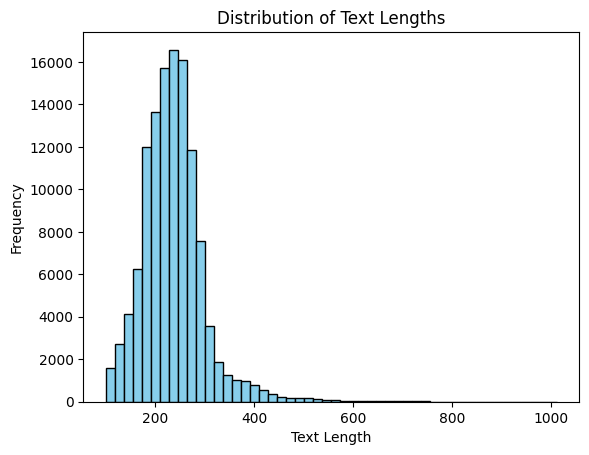

In [6]:
plt.hist(train_df['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [7]:
import string


def preprocess(text):
    text = text.lower() 
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

train_df['cleaned_text'] = train_df['text'].apply(preprocess)


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(train_df['cleaned_text'])

word_freq = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

word_freq_df = pd.DataFrame({'word': words, 'frequency': word_freq})
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

print(word_freq_df.head(10))


             word  frequency
6291          39s      31218
62717         new      21213
79698        said      19995
77869     reuters      17243
14063          ap      16148
100371      world       7464
60257      monday       7440
98764   wednesday       7317
94043     tuesday       7253
65060         oil       7205


# PREPROCESSING

In [9]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
        return tokenizer(examples['text'], padding=True, truncation=True, max_length=128)
    

tokenized_datasets = dataset.map(tokenize_function, batched=True)


In [10]:
print(tokenized_datasets['train'][0])

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2, 'input_ids': [101, 2813, 2358, 1012, 6468, 15020, 2067, 2046, 1996, 2304, 1006, 26665, 1007, 26665, 1011, 2460, 1011, 19041, 1010, 2813, 2395, 1005, 1055, 1040, 11101, 2989, 1032, 2316, 1997, 11087, 1011, 22330, 8713, 2015, 1010, 2024, 3773, 2665, 2153, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Tensor TF Dataset

In [11]:
print(type(dataset['train']['text']))

<class 'datasets.arrow_dataset.Column'>


### Forms of dataset from hugging face is column <-> but tokenizer is suited for string 

In [12]:
text_df = dataset['train'].to_pandas()
train_text = text_df['text'].tolist()


test_df = dataset['test'].to_pandas()
test_text = test_df['text'].to_list()


### this stage for filtering the dat of input to model
### after tokenizer, return a dict

In [13]:

train_encoding = tokenizer(train_text,truncation = True, padding = True, max_length = 128)

test_encoding = tokenizer(train_text, padding = True, truncation = True, max_length = 128)




In [14]:
train_label = dataset['train']['label']
test_label = dataset['test']['label']

## Method to input data to Tensor TF : from_tensor_slices
### !! BUT this method just allow for list() or numpy array 

In [15]:
train_input_ids = list(train_encoding['input_ids'])
train_attention_mask = list(train_encoding['attention_mask'])
train_labels = list(train_label)

test_input_ids = list(test_encoding['input_ids'])
test_attention_mask = list(test_encoding['attention_mask'])
test_labels = list(test_label)
test_input_ids = test_input_ids[:len(test_labels)]
test_attention_mask = test_attention_mask[:len(test_labels)]

print(len(train_input_ids), len(train_attention_mask), len(train_labels))
print(len(test_input_ids), len(test_attention_mask), len(test_labels))

train_dataset = tf.data.Dataset.from_tensor_slices((
    np.array(train_input_ids), 
    np.array(train_attention_mask), 
    np.array(train_labels)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    np.array(test_input_ids),
    np.array(test_attention_mask),
    np.array(test_labels)
))



120000 120000 120000
7600 7600 7600


I0000 00:00:1764878195.480181   36672 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5309 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


# TRAIN MODEL

## Finetune with transformers in Hugging Face - DistilBert

In [17]:
import torch
print(torch.__version__)  # Kiểm tra phiên bản PyTorch
print(torch.cuda.is_available())  # Kiểm tra xem GPU có sẵn không


ModuleNotFoundError: No module named 'torch'

In [ ]:
from transformers import Trainer, DistilBertForSequenceClassification, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 4, force_download=True)


ImportError: 
DistilBertForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFDistilBertForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


## TrainingArguments : define the way how model have to learn

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    logging_dir='Log',
    logging_steps = 10,
    evaluation_strategy = "epoch"
    
)

NameError: name 'TrainingArguments' is not defined